In [598]:
import pandas as pd
import numpy as np
import operator
from pandas.tseries.offsets import DateOffset
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib
import sys
import os
%matplotlib inline

In [599]:
class Spike(object):
    counter = 1
    def __init__(self, start, end,diff, df):
        self.start = start
        self.end = end
        self.dur = end - start
        self.diff = diff
        self.slope = diff/float(self.end - self.start)
        self.size = 0
    
    def fill_tweets(self, df):
        all_tweets = [tweet.lower() for tweet in df[(df.m > self.start) & (df.m <= self.end)]['text'].values]
        self.rows = df[(df.m > self.start) & (df.m <= self.end)]
        self.size = len(all_tweets)
        self.tweets = '\n'.join(all_tweets)
    
    def write(self,dir_):
        filename = dir_ + str(self.__class__.counter) + '.spike'
        text = self.__str__() + '\n' + self.tweets
        with open(filename, "w") as spike_out:
            spike_out.write(text)
            self.__class__.counter += 1
    def __str__(self):
        return 'time:%d-%d, diff:%d, slope:%d, tweet size:%d' %(self.start, self.end, self.diff, self.slope, self.size)

In [600]:
def to_min(d):
    d = d + timedelta(seconds=threshold*60)
    minute = (86400* (d-start_time).days + (d-start_time).seconds)/60
    return minute

In [601]:
def filter_tweets_divided(tweets):
    filtered = tweets[tweets['m'] > 0]
    filtered = filtered[filtered['m'] < 120]
    #return filtered
    #filtered = filtered[(filtered['text'].str.contains('CHEARS'))]
    #filtered = filtered[(filtered['text'].str.contains('CFC')) 
    #                   | (filtered['text'].str.contains('AFC'))
    #                  ]
    return filtered

In [602]:
def half_tweets(tweets):
    first_half = tweets[tweets['m']< 50]
    second_half = tweets[(tweets['m'] > 60) & (tweets['m'] < 120)]
    return first_half, second_half

In [603]:
def get_spikes(grouped, start=0): #Start value can be 1 or 45 for first half and second half
    row = 0 #set current row to begining
    spikes = []
    while True:
        cur_tweet_count = grouped.values[row][0] #Tweet Count of row = row, i.e. Total tweets in first minute
        start_index = row
        end_index = row
        diff = 0
        row = row + 1 #Read Next Row
        if not row + start >= np.max(grouped.index.values): #If next row is not last row, enter if
            next_tweet_count = grouped.values[row][0]    #Get tweet count for next row
            while next_tweet_count - cur_tweet_count > diff_threshold: #If difference to previous row is greater than threshold
                end_index = row #Set end index as this row
                diff += next_tweet_count - cur_tweet_count
                cur_tweet_count = next_tweet_count #Update current tweet count as next, 
                row = row + 1 #and move to next row
                if not row + start >= np.max(grouped.index.values): #If next row is not the end,
                    next_tweet_count = grouped.values[row][0] #get tweet count
                else:
                    break #if next row is end, break.
            if end_index - start_index > 0: #If start and end has at least one minute diff, create spike and add to list
                spikes.append(Spike(start_index + start, end_index + start, diff, grouped))

        else:
            break
    spikes.sort(key=operator.attrgetter('diff'), reverse=True)
    return spikes

In [604]:
filename='../config/config-swabou.txt'
config = {}
if len(sys.argv) > 2 and sys.argv[1] != '-f':
    filename=sys.argv[1]
else:
    print 'Running with default config'
    with open(filename,'r') as configfile:
        for line in configfile:
            if line.startswith('#'):
                continue
            name,var=line.partition('=')[::2]
            config[name.strip()]=var.strip()
start_time = datetime.strptime(config['kotime'], '%Y,%m,%d,%H,%M')

Running with default config


In [605]:
tweets= pd.read_csv('../data/%s.csv'%config['db'])

In [606]:
tweets['created_at'] = pd.to_datetime(pd.Series(tweets['created_at'])).apply(lambda d: d + timedelta(hours=1))

In [607]:
fh_added_time=int(config['fh_added_time'])
sh_added_time=int(config['sh_added_time'])
threshold=1
diff_threshold = 50 # only spikes with difference in tweet count in a minute greater than this value is considered.

In [608]:
tweets['m']=tweets.created_at.apply(to_min)

In [609]:
first_half, second_half = half_tweets(tweets)
fh_filtered=filter_tweets_divided(first_half)
sh_filtered=filter_tweets_divided(second_half)
sh_filtered['m'] = sh_filtered.m.apply(lambda d: d - 15 - fh_added_time-threshold)
sh_filtered = sh_filtered[sh_filtered['m'] >= 45]

In [610]:
grouped_fh = fh_filtered.groupby('m').count()
grouped_sh = sh_filtered.groupby('m').count()

In [611]:
fh_spikes = get_spikes(grouped_fh, 1)
sh_spikes = get_spikes(grouped_sh, 45)
dir_ = '../results/%s/'%(config['db'])
if not os.path.exists(dir_):
    os.makedirs(dir_)
for spike in fh_spikes:
    spike.fill_tweets(fh_filtered)
    spike.write(dir_ + 'fh')
    print spike
Spike.counter=1
for spike in sh_spikes:
    spike.fill_tweets(sh_filtered)
    spike.write(dir_+'sh')
    print spike

time:26-28, diff:391, slope:195, tweet size:626
time:38-40, diff:270, slope:135, tweet size:400
time:10-12, diff:138, slope:69, tweet size:245
time:94-95, diff:55, slope:55, tweet size:74


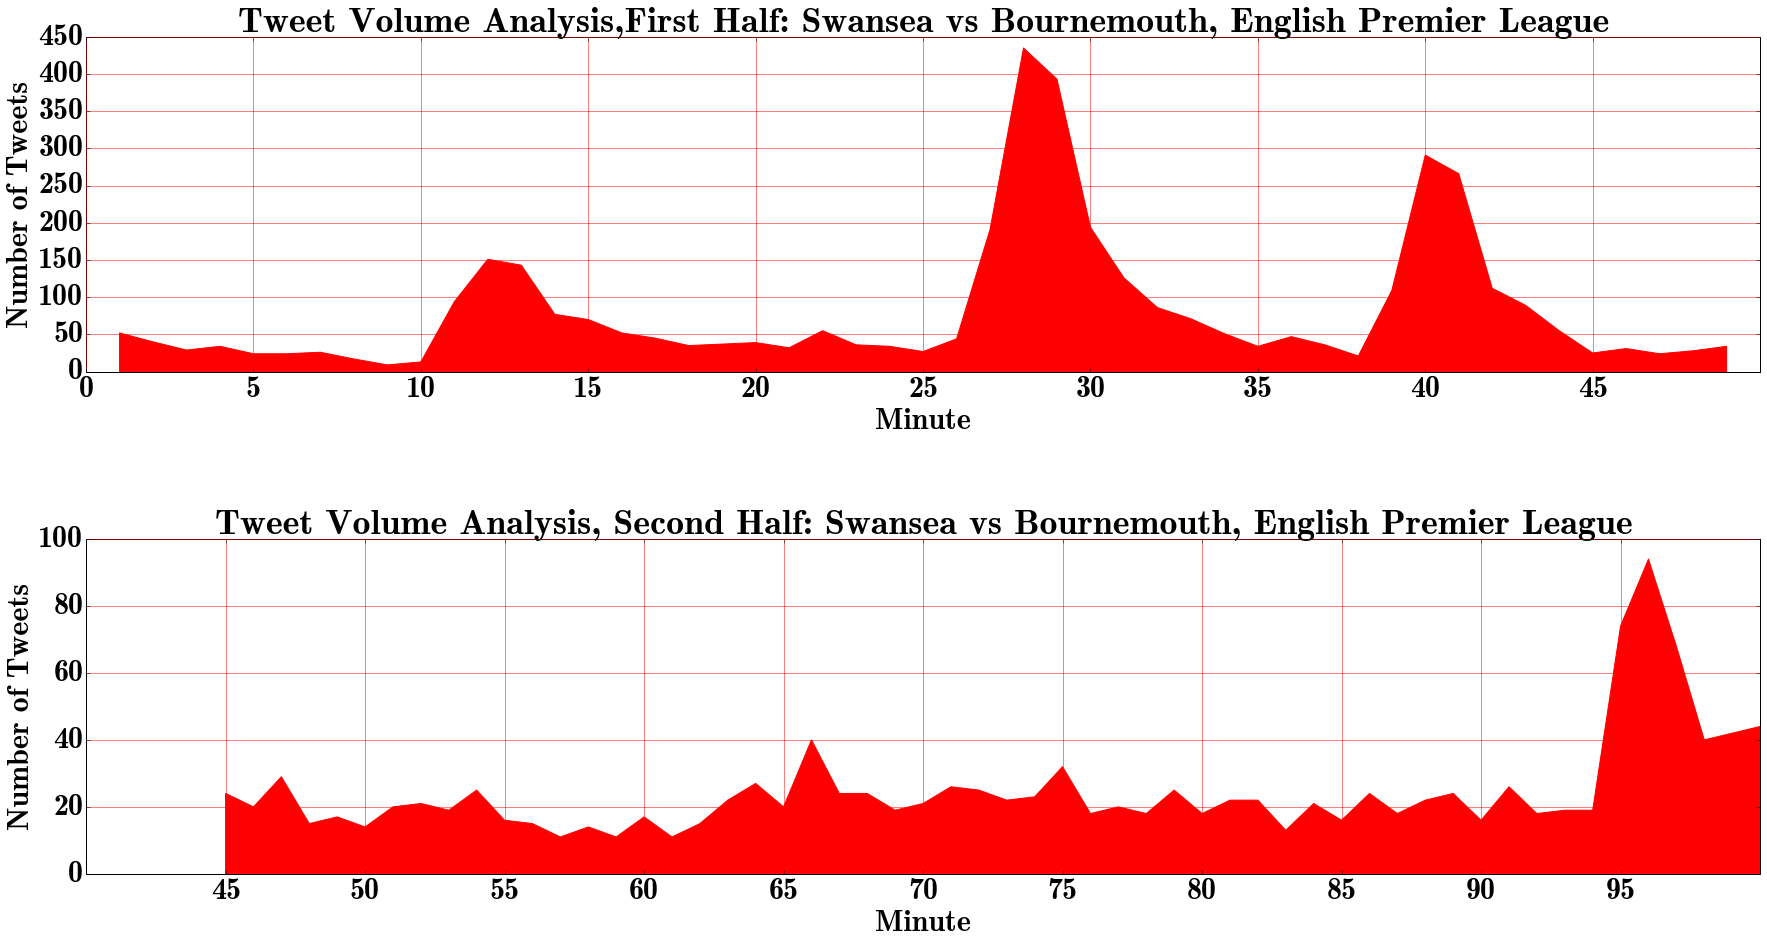

In [612]:
# let us make a simple graphfh
fig_size = 10
font_size = 2.5
font = {
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=[fig_size*3,fig_size*1.5])
plt.subplots_adjust(hspace=.5)

# set the grid on
plt.grid(color='r', linestyle='-', linewidth=0.5, which='major')
plt.xticks(range(0,100,5))


plt.subplot2grid((2,2), (0,0), colspan=2)
plt.fill_between(grouped_fh.index, grouped_fh['text'], color='red')
# set the basic properties
plt.xlabel('Minute')
plt.ylabel('Number of Tweets')
plt.title('Tweet Volume Analysis,First Half: %s' %config['game'])
# set the limits
#ax.set_xlim(0, 24)
#ax.set_ylim(6, 24)

# set the grid on
plt.grid(color='r', linestyle='-', linewidth=0.5, which='major')
plt.xticks(range(0,50,5))

plt.subplot2grid((2,2), (1,0), colspan=2)
plt.fill_between(grouped_sh.index, grouped_sh['text'], color='red')
# set the basic properties
plt.xlabel('Minute')
plt.ylabel('Number of Tweets')
plt.title('Tweet Volume Analysis, Second Half: %s'%config['game'])
# set the limits
#ax.set_xlim(0, 24)
#ax.set_ylim(6, 24)

# set the grid on
plt.grid(color='r', linestyle='-', linewidth=0.5, which='major')
plt.xticks(range(45,100,5))
fig.savefig(dir_ + 'plot.png')